# Customer Churn Prediction with PySpark

In [1]:
!pip install pyspark

     |████████████████████████████████| 212.3 MB 11 kB/s 
     |████████████████████████████████| 198 kB 32.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=b3bff273e42b107d7d4e79d8f6d4ba609214e5122365103a6431d08d07954e9d
  Stored in directory: /root/.cache/pip/wheels/43/47/42/bc413c760cf9d3f7b46ab7cd6590e8c47ebfd19a7386cd4a57
Successfully built pyspark


In [2]:
# import libraries
import time
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml import feature as FT
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# set up a Spark session
spark = SparkSession \
        .builder \
        .appName('Sparkify Churn Prediction') \
        .getOrCreate()

In [4]:
# Check, if Spark session was setup correctly
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1615023359481'),
 ('spark.driver.host', '972e9f98de55'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1615023360792'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.warehouse.dir', 'file:/kaggle/working/spark-warehouse'),
 ('spark.driver.port', '41035'),
 ('spark.app.name', 'Sparkify Churn Prediction'),
 ('spark.ui.showConsoleProgress', 'true')]

# About the Dataset
We will use the user events logs (duration about 2 months) of a music-streaming service called Sparkify as our dataset. With these logs we can predict whether this user is more likely to stay or is more likely to churn. The dataset contains 286,500 rows and 18 features:

* artist: singer of a song
* auth: login status
* firstName: first name of the user
* gender: gender of the user
* itemInSession: number of the item in the current session
* lastName: surname of the user
* length: song length
* level: whether a customer is paying for the service or not
* location: location of the user
* method: how a user is getting web pages
* page: page browsing information
* registration: time stamp of the regestration of the user
* sessionId: session ID
* song: name of a song
* status: page return code
* ts: timestamp of the log item
* userAgent: browser client
* userId: user ID

# 1. Load and Clean Data

In [5]:
# Load dataset
df = spark.read.json('../input/mini-sparkify/mini_sparkify_event_data.json')

In [6]:
# show number of rows
df.count()

286500

In [7]:
# show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# show first rows
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [9]:
# check missing (NaN) values in all columns
count_nan_cols = [F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns]
df.select(count_nan_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* No missing(NaN) values in all columns.

In [10]:
# check Null values in all columns
count_null_cols = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]
df.select(count_null_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


* Null values are found in columns related with user information and song information.

In [11]:
df.filter(F.col('artist').isNull()).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


In [12]:
df.filter(F.col('artist').isNull()!=True).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


* Pages that are not NextSong will have null values for artist, length and song.

In [13]:
# check empty columns per column
count_invalid_cols = [F.count(F.when(F.col(c)=='', c)).alias(c) for c in df.columns]
df.select(count_invalid_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


In [14]:
# check out rows with empty userId 
df.filter(F.col('userId')=='').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,


* Users with empty userId are those who did not register and log in.

In [15]:
# drop rows with missing user id
df = df.where(df.userId!='')

# drop duplicate rows if any exists
df = df.dropDuplicates()

df.count()

278154

# 2. Exploratory Data Analysis

In [16]:
# use the Cancellation Confirmation event to define churn
churned_users = df.filter(F.col('page')=='Cancellation Confirmation')

flag_churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())
df = df.withColumn('churn', flag_churn('page'))

churned_users.count()

52

In [17]:
# convert Timestamps (ts) to Datetime
df = df.withColumn('reg_date', (F.col('registration')/1000).cast(T.TimestampType()))
df = df.withColumn('date', (F.col('ts')/1000).cast(T.TimestampType()))

# user-based observation start/end dates
min_date = df.agg({'date':'min'}).collect()[0]['min(date)']
max_date = df.agg({'date':'max'}).collect()[0]['max(date)']
min_reg_date = df.agg({'reg_date':'min'}).collect()[0]['min(reg_date)']
max_reg_date = df.agg({'reg_date':'max'}).collect()[0]['max(reg_date)']
print(f'min_date:{min_date}')
print(f'max_date:{max_date}')
print(f'min_reg_date:{min_reg_date}')
print(f'max_reg_date:{max_reg_date}')

min_date:2018-10-01 00:01:57
max_date:2018-12-03 01:11:16
min_reg_date:2018-03-18 13:44:35
max_reg_date:2018-11-26 15:49:14


In [18]:
# get first log date
w = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn('first_date', F.first('date').over(w))

# infer observation start date
df = df.withColumn('obs_start',
                  (F.when(F.col('reg_date')<min_date, min_date)
                    .when(F.col('reg_date')<F.col('first_date'), F.col('reg_date'))
                    .otherwise(F.col('first_date')))
                  )

# infer observation end date
df = df.withColumn('obs_end',
                  (F.when(F.last('churn').over(w)==1, F.last('date').over(w))
                     .otherwise(max_date))
                  )

In [19]:
# get hour, weekday out of the date
df = df.withColumn('hour', F.date_format(F.col('date'), 'H'))
df = df.withColumn('weekday', F.date_format(F.col('date'), 'E'))

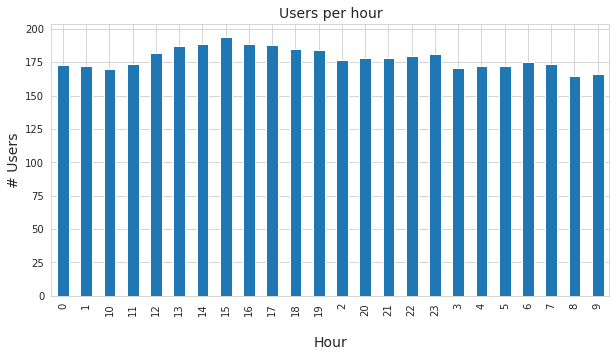

In [20]:
# user distribution per hour of the day
users_per_hour_pd = df.select(['userId', 'hour']).dropDuplicates().groupBy(['hour']).count().sort('hour').toPandas()

# observe the distribution
ax = users_per_hour_pd.plot(x='hour', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nHour', fontsize=14)
plt.ylabel('# Users', fontsize=14)
plt.title('Users per hour', fontsize=14)
plt.show()

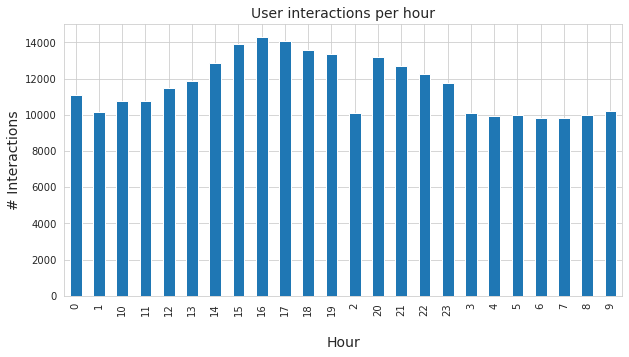

In [21]:
# user interaction per hour
interactions_per_hour_pd = df.select(['userId', 'hour']).groupBy(['hour']).count().sort('hour').toPandas()

# plot the interactoins
ax = interactions_per_hour_pd.plot(x='hour', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nHour', fontsize=14)
plt.ylabel('# Interactions', fontsize=14)
plt.title('User interactions per hour', fontsize=14)
plt.show()

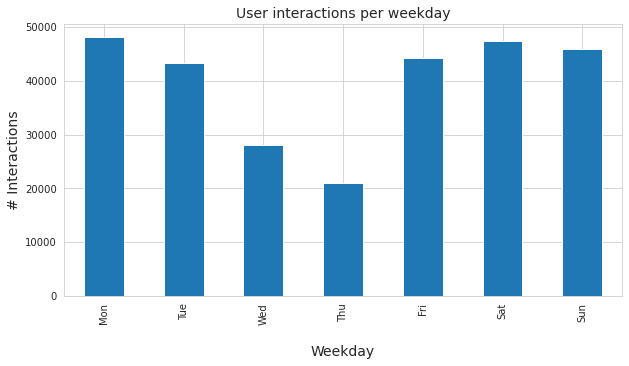

In [22]:
# user interactions per weekday
interactions_per_weekday_pd = df.select(['userId', 'weekday']).groupBy(['weekday']).count().sort('weekday').toPandas()

# plot
ax = interactions_per_weekday_pd.plot(x='weekday', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('\nWeekday', fontsize=14)
plt.ylabel('# Interactions', fontsize=14)
plt.title('User interactions per weekday', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

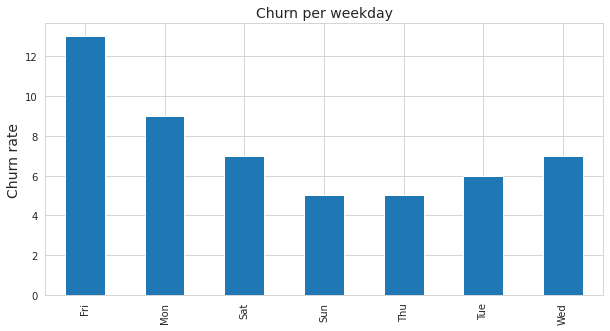

In [23]:
# churn per weekday
churn_per_weekday_pd = df.select(['userId', 'weekday', 'churn']).groupby(['weekday']).sum().sort('weekday').toPandas()

# plot
ax = churn_per_weekday_pd[['weekday','sum(churn)']].plot(x='weekday', kind='bar', figsize=(10,5))
ax.get_legend().remove()
plt.xlabel('', fontsize=14)
plt.ylabel('Churn rate', fontsize=14)
plt.title('Churn per weekday', fontsize=14)
plt.show()

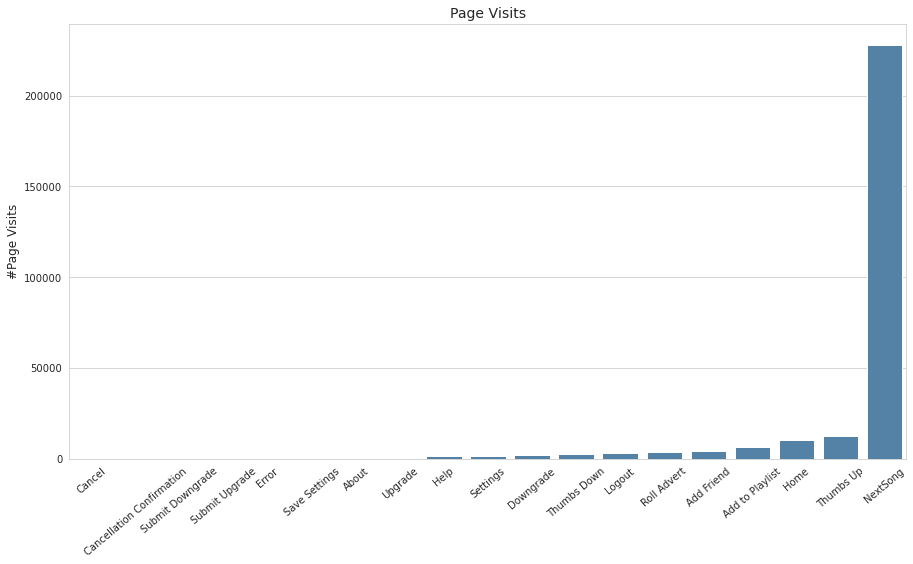

In [24]:
# number of page visits
page_visits_pd = df.groupBy('page').count().toPandas().sort_values('count')

# plot all page events in the dataset:
plt.figure(figsize=(15,8))
sns.barplot(x='page', y='count', data=page_visits_pd, color='steelblue')
plt.title('Page Visits', fontsize=14)
plt.xticks(rotation=40)
plt.xlabel('', fontsize=12)
plt.ylabel('#Page Visits', fontsize=12)
plt.show();

# 3. Feature Engineering

Now that we've familiarized ourselves with the data set, we try to find and build promising features to train the model on:

* aggregate all necessary columns by user
* extract features from 'page' column which keeps track of pages a user visits
* extract some duration-based features related with events

In [25]:
# last subscription level
df = df.withColumn('last_level', F.last('level').over(w))

In [26]:
# aggregation by user
user_df = df.groupby('userId').agg(
    
    # User-level features
    F.max('churn').alias('churn'),
    F.first('gender').alias('gender'),
    F.first('reg_date').alias('reg_date'),
    F.first('obs_start').alias('obs_start'),
    F.first('obs_end').alias('obs_end'),
    F.first('last_level').alias('last_level'),
    )

user_df = user_df.withColumn('user_lifetime', F.datediff('obs_end', 'reg_date'))

In [27]:
# aggregation by user
page_df = df.groupby('userId').agg(
    
    # interaction-level features (exclude Cancellation Confirmation)
    F.count('page').alias('total_actions'),
    F.sum(F.when(F.col('page')=='About', 1).otherwise(0)).alias('page_about'),
    F.sum(F.when(F.col('page')=='Add Friend', 1).otherwise(0)).alias('page_add_friend'),
    F.sum(F.when(F.col('page')=='Add to Playlist', 1).otherwise(0)).alias('page_addtoplaylist'),
    F.sum(F.when(F.col('page')=='Cancel', 1).otherwise(0)).alias('page_cancel'),
    F.sum(F.when(F.col('page')=='Downgrade', 1).otherwise(0)).alias('page_downgrade'),
    F.sum(F.when(F.col('page')=='Error', 1).otherwise(0)).alias('page_error'),
    F.sum(F.when(F.col('page')=='Help', 1).otherwise(0)).alias('page_help'),
    F.sum(F.when(F.col('page')=='Home', 1).otherwise(0)).alias('page_home'),
    F.sum(F.when(F.col('page')=='Logout', 1).otherwise(0)).alias('page_logout'),
    F.sum(F.when(F.col('page')=='NextSong', 1).otherwise(0)).alias('page_song'),
    F.sum(F.when(F.col('page')=='Roll Advert', 1).otherwise(0)).alias('page_roll_advert'),
    F.sum(F.when(F.col('page')=='Save Settings', 1).otherwise(0)).alias('page_save_settings'),
    F.sum(F.when(F.col('page')=='Settings', 1).otherwise(0)).alias('page_settings'),
    F.sum(F.when(F.col('page')=='Submit Downgrade', 1).otherwise(0)).alias('page_submit_downgrade'),
    F.sum(F.when(F.col('page')=='Submit Upgrade', 1).otherwise(0)).alias('page_submit_upgrade'),
    F.sum(F.when(F.col('page')=='Thumbs Down', 1).otherwise(0)).alias('page_thumbs_down'),
    F.sum(F.when(F.col('page')=='Thumbs Up', 1).otherwise(0)).alias('page_thumbs_up'),
    F.sum(F.when(F.col('page')=='Upgrade', 1).otherwise(0)).alias('page_upgrade'),
)

In [28]:
# aggregation by user
song_df = df.groupby('userId').agg(
    
    # song-level features
    F.countDistinct('artist').alias('total_artists'),
    F.sum('length').alias('total_length'),
)

In [29]:
# aggregation by user
session_df = df.groupby('userId').agg(
    
    # session-level features
    F.countDistinct('sessionId').alias('total_sessions'),
)

In [30]:
# bringing all together
df = user_df.join(page_df, ['userId'])\
                .join(song_df, ['userId'])\
                .join(session_df, ['userId'])

In [31]:
# only use these variables
df = df.select('userId', 'churn', 'gender', 'last_level', 'total_actions',
               'page_about', 'page_add_friend', 'page_addtoplaylist', 'page_cancel',
               'page_downgrade', 'page_error', 'page_help', 'page_home', 'page_logout',
               'page_song', 'page_roll_advert', 'page_save_settings', 'page_settings', 
               'page_submit_downgrade', 'page_submit_upgrade', 'page_thumbs_down', 
               'page_thumbs_up', 'page_upgrade', 'total_artists', 'total_length', 
               'total_sessions', 'user_lifetime')

In [32]:
# convert to pandas dataframe for easy visualization
df_pd = df.toPandas()
df_pd.shape

(225, 27)

In [33]:
df_pd.head(5)

,userId,churn,gender,last_level,total_actions,page_about,page_add_friend,page_addtoplaylist,page_cancel,page_downgrade,page_error,page_help,page_home,page_logout,page_song,page_roll_advert,page_save_settings,page_settings,page_submit_downgrade,page_submit_upgrade,page_thumbs_down,page_thumbs_up,page_upgrade,total_artists,total_length,total_sessions,user_lifetime
0,100010,0,F,free,381,1,4,7,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2,252,6.694090e+04,7,67
1,200002,0,M,paid,474,3,4,8,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2,339,9.400888e+04,6,88
2,125,1,M,free,11,0,0,0,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0,8,2.089113e+03,1,124
3,124,0,F,paid,4825,7,74,118,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0,2232,1.012312e+06,29,134
4,51,1,M,paid,2464,2,28,52,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0,1385,5.232758e+05,10,20


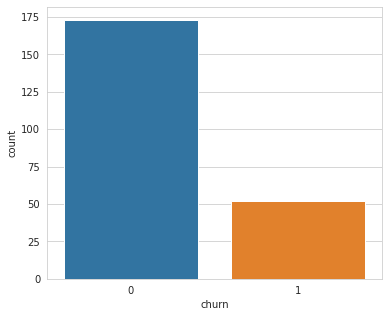

In [34]:
# observe the behavior for users who stayed vs users who churned
plt.figure(figsize=(6,5))
sns.countplot(x='churn', data=df_pd)
# plt.savefig('dist_churn.png')
plt.show();

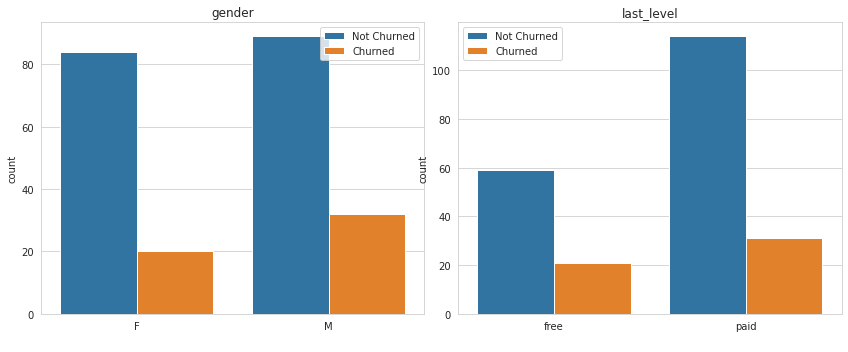

In [35]:
# categorical columns
cat_cols = df_pd.select_dtypes('object').columns.tolist()
cat_cols.remove('userId')

# observe the distribution of categorical features
plt.figure(figsize=(12,5))

for i in range(len(cat_cols)):
    plt.subplot(1, 2, i+1)
    plt.tight_layout()
    sns.countplot(x=cat_cols[i], data=df_pd, hue='churn')
    plt.legend(['Not Churned', 'Churned'])
    plt.title(cat_cols[i])
    plt.xlabel(' ')
    
# plt.savefig('dist_categorical.png')
plt.show();

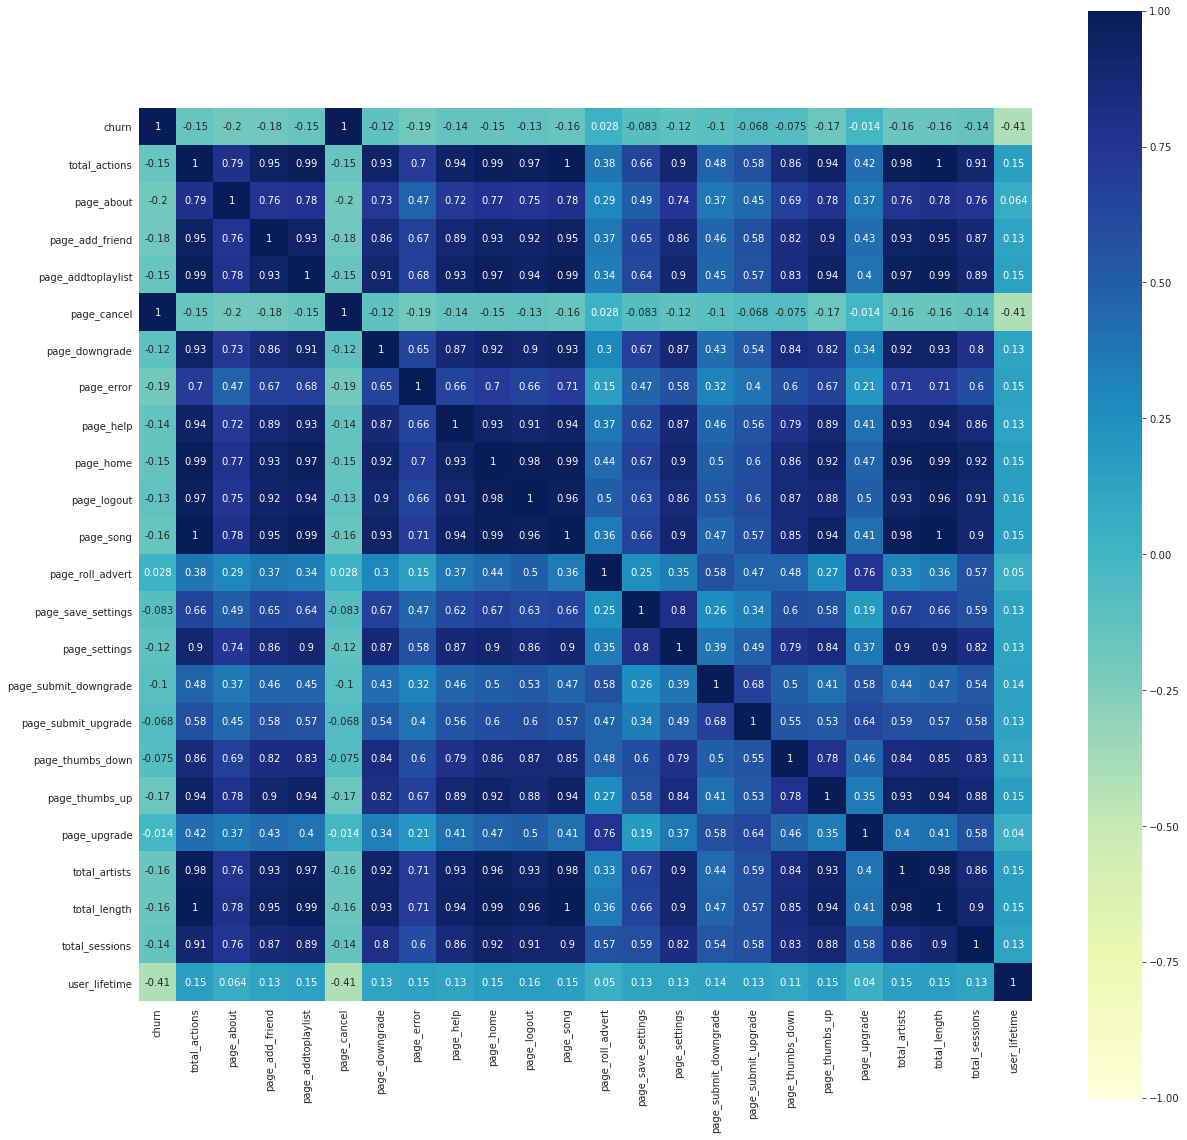

In [36]:
# numerical columns
num_cols = df_pd.select_dtypes(include=np.number).columns.tolist()

# a function to plot correlation among columns
def plot_corr(cols, figsize=(10, 10), filename=None, df=df_pd):
    plt.figure(figsize=figsize)
    sns.heatmap(df[cols].corr(),square=True, cmap='YlGnBu', annot=True, vmin=-1, vmax=1)
    plt.ylim(len(cols), 0)
    if filename:
        plt.savefig(filename)
    plt.show();
    
# observe the correlation between numerical features
plot_corr(num_cols, figsize=(20, 20))

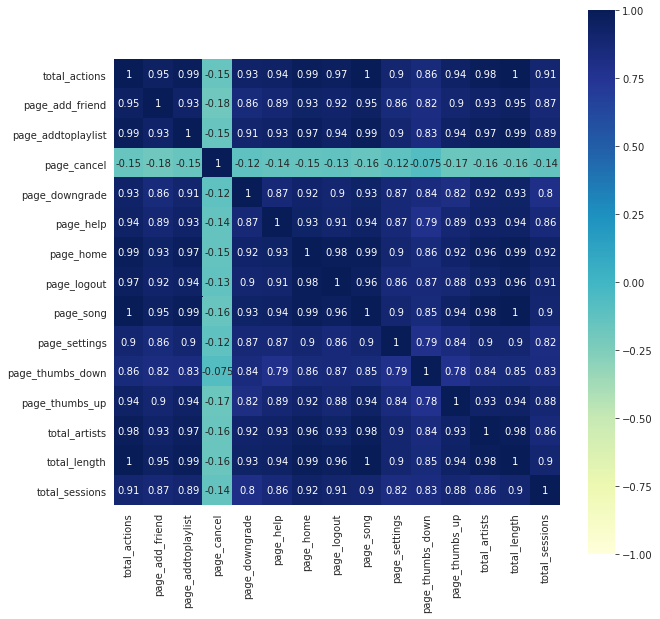

In [37]:
correlation_matrix = df_pd.corr('pearson')

# Identify features that higly correlate with any other feature
max_corr = 0.85 # Set parameter for maximum permitted pearson correlation coefficient

# Loop over columns
highly_correlated_columns = []
for column in correlation_matrix.columns:
    if (column != 'churn') & (correlation_matrix[column].drop(column).max() > max_corr):
        highly_correlated_columns.append(column)     
        
# plot highly correlated columns
plot_corr(highly_correlated_columns)

Highly correlated (>0.85) variable pairs(groups):

* total_artists, total_length, total_sessions, total_actions
* page_add_friend, page_addtoplaylist, page_downgrade, page_help, page_home, page_logout, page_song, page_settings, page_thumbs_down, page_thumbs_up

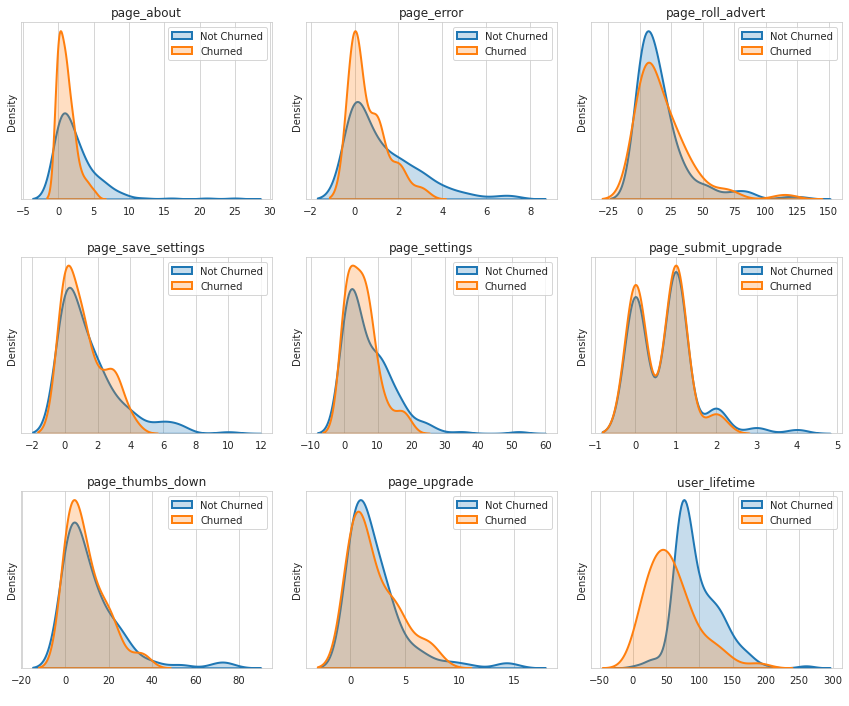

In [38]:
# observe the distribution of numerical features
drop_col = ['total_actions', 'page_add_friend', 'page_addtoplaylist', 'page_cancel', 
            'page_downgrade', 'page_home', 'page_help', 'page_logout', 'page_song',
            'page_thumbs_up', 'page_submit_downgrade', 'total_artists','total_length', 
            'total_sessions']          

num_cols = [col for col in num_cols if col not in drop_col]
num_cols.remove('churn')

plt.figure(figsize=(12, 16))
for i in range(len(num_cols)):
    plt.subplot(5,3,i+1)
    plt.tight_layout()
    sns.distplot(df_pd[df_pd['churn']==0][num_cols[i]],
                 hist=False, norm_hist=True, kde_kws={'shade': True, 'linewidth': 2})
    sns.distplot(df_pd[df_pd['churn']==1][num_cols[i]],
                 hist=False, norm_hist =True, kde_kws={'shade': True, 'linewidth': 2})
    plt.legend(['Not Churned','Churned'])
    plt.title(num_cols[i])
    plt.xlabel(' ')
    plt.yticks([])

# plt.savefig('dist_numerical.png')
plt.show();

* Most of the numerical features are skewed. 

The range of values in a feature should reflect their importance. Higher values imply higher importances. Some features might have larger values than others and are required to be transformed for equal importance. There are two common methods to do feature scaling: 

1. **Normalization**: 
Normalize numerical features to range [0,1] e.g. via min-max normalization: Normalised Value = (Value - Feature Min)/(Feature Max - Feature Min)

2. **Standardization**: 
The Central Limit Theorem guarantees that the average of independent random variables is approximately normally distributed even when the individual random variables are not normally distributed. By standardization you ensure the values in a feature follow the normal distribution whereby mean of the values is 0 and standard deviation is 1. Standardized Value = (Value - Feature Mean)/Feature Standard Deviation

In [39]:
# now we have 15 features in total (excluding the userId and label(churn) columns)
reverse_cols = [col for col in df.columns if col not in drop_col]
df = df.select(*reverse_cols).withColumnRenamed('churn', 'label')
df.persist()
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_level: string (nullable = true)
 |-- page_about: long (nullable = true)
 |-- page_error: long (nullable = true)
 |-- page_roll_advert: long (nullable = true)
 |-- page_save_settings: long (nullable = true)
 |-- page_settings: long (nullable = true)
 |-- page_submit_upgrade: long (nullable = true)
 |-- page_thumbs_down: long (nullable = true)
 |-- page_upgrade: long (nullable = true)
 |-- user_lifetime: integer (nullable = true)



In [40]:
cat_cols

['gender', 'last_level']

In [41]:
num_cols

['page_about',
 'page_error',
 'page_roll_advert',
 'page_save_settings',
 'page_settings',
 'page_submit_upgrade',
 'page_thumbs_down',
 'page_upgrade',
 'user_lifetime']

In [42]:
# build data-process stages to encode, scale and assemble features
stages = []

# encode categorical features
for col in cat_cols:
    indexer = FT.StringIndexer(inputCol=col, outputCol=col+'_idx')
    encoder = FT.OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col+'_vec'])
    stages += [indexer, encoder]

# scale numeric features via standartization so that they are closer to normal distribution
for col in num_cols: 
    assembler = FT.VectorAssembler(inputCols=[col], outputCol=col+'_vec')
    scaler = FT.MinMaxScaler(inputCol=col+'_vec', outputCol=col+'_scl')
    stages += [assembler, scaler]

# assemble features  into a feature vector
input_cols = [c+'_vec' for c in cat_cols] + [c+'_scl' for c in num_cols]
assembler = FT.VectorAssembler(inputCols=input_cols, outputCol='features')
stages += [assembler]

# 4. Modeling

In [43]:
# split data into train and test sets, sample by label
ratio = 0.7
train = df.sampleBy('label', fractions={0:ratio, 1:ratio}, seed=123)
test = df.subtract(train)

print('train set:')
train.groupBy('label').count().show()
print('test set:')
test.groupBy('label').count().show()

train set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   40|
|    0|  124|
+-----+-----+

test set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   12|
|    0|   49|
+-----+-----+



In [44]:
lr = LogisticRegression(maxIter=10)
gbt = GBTClassifier(seed=42)
rfc = RandomForestClassifier(seed=42)

pipelines = [
    Pipeline(stages=stages+[lr]),
    Pipeline(stages=stages+[gbt]),
    Pipeline(stages=stages+[rfc]),
]

for model, pipeline in zip([lr, gbt, rfc], pipelines):
    print('\n', type(model))
    
    # start training
    start = time.time()
    model = pipeline.fit(train)
    end = time.time()
    print(f'train time: {end-start:.0f}s')
    
    # make predictions
    pred_train = model.transform(train)
    pred_test = model.transform(test)
    
    # evaluate with F1-score which better suits for inbalanced dataset
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    f1_score = evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})
    print("Training f1 score: {}".format(f1_score))
    f1_score = evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})
    print("Testing f1 score: {}".format(f1_score))


 <class 'pyspark.ml.classification.LogisticRegression'>
train time: 45s
Training f1 score: 0.8533230320520446
Testing f1 score: 0.8032786885245901

 <class 'pyspark.ml.classification.GBTClassifier'>
train time: 177s
Training f1 score: 1.0
Testing f1 score: 0.849996760189205

 <class 'pyspark.ml.classification.RandomForestClassifier'>
train time: 34s
Training f1 score: 0.9298501457640214
Testing f1 score: 0.8441115774340899


# 5. Results

In [45]:
rfc_feature_importance_df = pd.DataFrame()
rfc_feature_importance_df['features'] = cat_cols + num_cols
rfc_feature_importance_df['importance'] = model.stages[-1].featureImportances.values.tolist()
rfc_feature_importance_df = rfc_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rfc_feature_importance_df

,features,importance
0,user_lifetime,0.607364
1,page_roll_advert,0.082462
2,page_settings,0.079930
3,page_thumbs_down,0.071314
4,page_error,0.048702
5,page_upgrade,0.038123
6,page_about,0.031319
7,page_submit_upgrade,0.016111
8,page_save_settings,0.015921
9,gender,0.007347


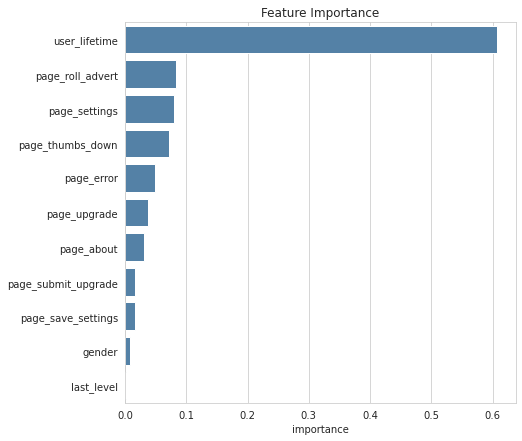

In [46]:
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='features', data=rfc_feature_importance_df, color='steelblue')
plt.title('Feature Importance')
plt.ylabel('')
plt.savefig('feature_importance.png');

Top important features:
* **user's lifetime** (total number of days after registration)
* **page_roll_advert** (ads watched)
* **page_settings** (settings checking event)
* **page_thumbs_down** (total number of thumbs down)


Less important features:

* **gender**, **level** (as we have explored it in EDA) 
* **page_submit_upgrade**, **page_save_settings**

Therefore we can remove them from the final model.